In [144]:
import sys
sys.path.append('../lib')
sys.path.append('../transform')
sys.path.append('../indicators')
sys.path.append('../predictors')
sys.path.append('../utilities')

# Import the Time Series library
import statsmodels.tsa.stattools as ts
from retrieve_issue_data import read_issue_data
from stat_tests import *
from compute_target import *
from lag_transform import *
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
plt.style.use('seaborn-ticks')
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.offsets import BDay
import matplotlib as mpl
plt.style.use('seaborn-ticks')
import matplotlib.ticker as ticker
%matplotlib inline

In [145]:
    issue = "tlt"
    us_cal = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    pivotDate = datetime.date(2018, 4, 2)
    inSampleOutOfSampleRatio = 2
    outOfSampleMonths = 2
    inSampleMonths = inSampleOutOfSampleRatio * outOfSampleMonths
    print("inSampleMonths: " + str(inSampleMonths))
    segments = 4
    months_to_load = outOfSampleMonths + segments * inSampleMonths
    print("Months to load: " + str(months_to_load))
       
    inSampleStartDate = pivotDate - relativedelta(months=months_to_load)
    dataLoadStartDate = inSampleStartDate - relativedelta(months=1)
    print("Load Date: ", dataLoadStartDate)
    print("In Sample Start  Date: ", inSampleStartDate)
    print("Pivot Date: ", pivotDate)
    
    dataSet = read_issue_data(issue, dataLoadStartDate, pivotDate)
    print(issue)
    nrows = dataSet.shape[0]
    print ("nrows: ", nrows)
    
    # set lag on Close (Pri)
    lag_var = 'Pri'
    lags = 5
    dataSet = add_lag(dataSet, lag_var, lags)
    
    # set % return variables and lags
    dataSet["percReturn"] = dataSet["Pri"].pct_change()*100
    lag_var = 'percReturn'
    lags = 5    
    dataSet = add_lag(dataSet, lag_var, lags)    

inSampleMonths: 4
Months to load: 18
Load Date:  2016-09-02
In Sample Start  Date:  2016-10-02
Pivot Date:  2018-04-02
Successfully retrieved Primary
tlt
nrows:  394


In [146]:
    #set beLong level
    beLongThreshold = 0

In [147]:
modelStartDate = inSampleStartDate
modelEndDate = modelStartDate + relativedelta(months=inSampleMonths)


In [148]:
def plot_v2x(data1, data2, title):
    numSubPlots = 2
    fig, axes = plt.subplots(numSubPlots, ncols=1, figsize=(numSubPlots*6,8), sharex=True)
    
    axes[0].plot(data1)
    axes[1].plot(data2, color='red', alpha =0.8)
    plt.subplots_adjust(hspace=0.05)
    fig.suptitle(title)
    fig.autofmt_xdate()
    for ax in axes:
                ax.label_outer()
                ax.legend(loc='upper left', frameon=True, fontsize=8)
                ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
                ax.grid(True, which='both')
                ax.xaxis_date()
                ax.autoscale_view()
                ax.grid(b=True, which='major', color='k', linestyle='-', alpha=0.6)
                ax.grid(b=True, which='minor', color='r', linestyle='-', alpha=0.2)
                ax.minorticks_on()
                #ax.tick_params(axis='y',which='minor',bottom='off')
    axes[1].set_yticks((-1,0,1), minor=False)
    return fig, (axes[0], axes[1])

nrows:  83
(83, 19)
beLong counts: 
-1    44
 1    39
Name: beLong, dtype: int64
out of  83
nrows:  84
(84, 19)
beLong counts: 
 1    48
-1    36
Name: beLong, dtype: int64
out of  84
nrows:  86
(86, 19)
beLong counts: 
 1    45
-1    41
Name: beLong, dtype: int64
out of  86
nrows:  81
(81, 19)
beLong counts: 
 1    42
-1    39
Name: beLong, dtype: int64
out of  81


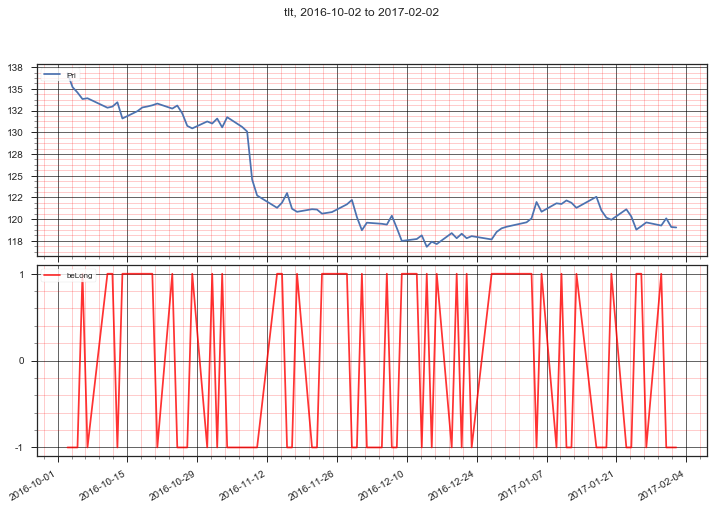

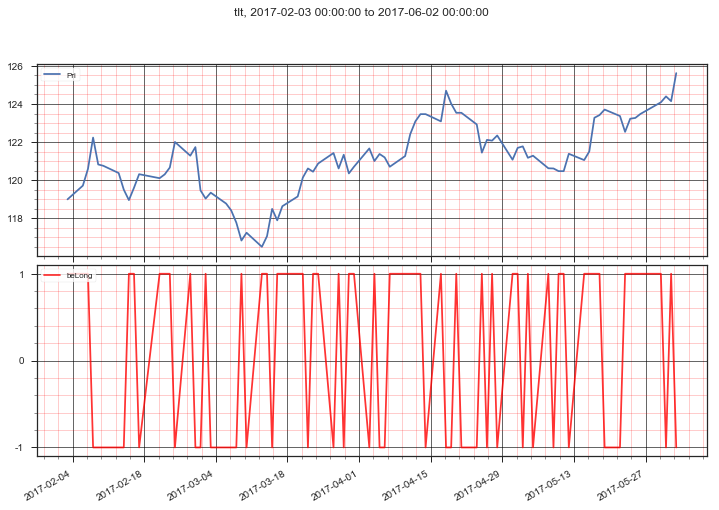

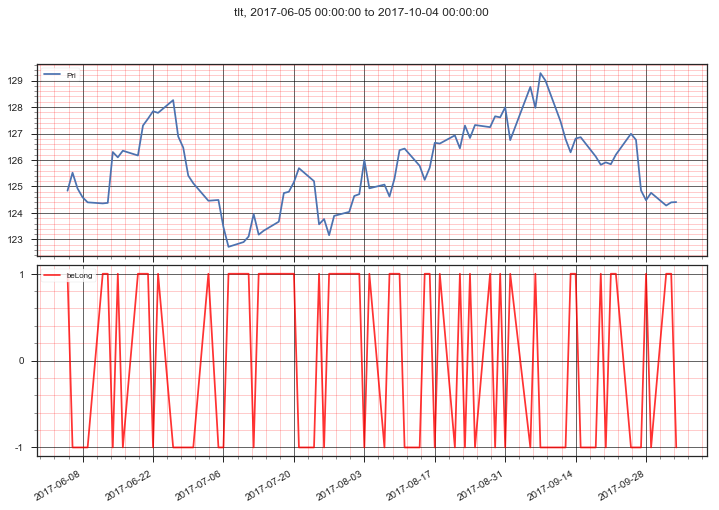

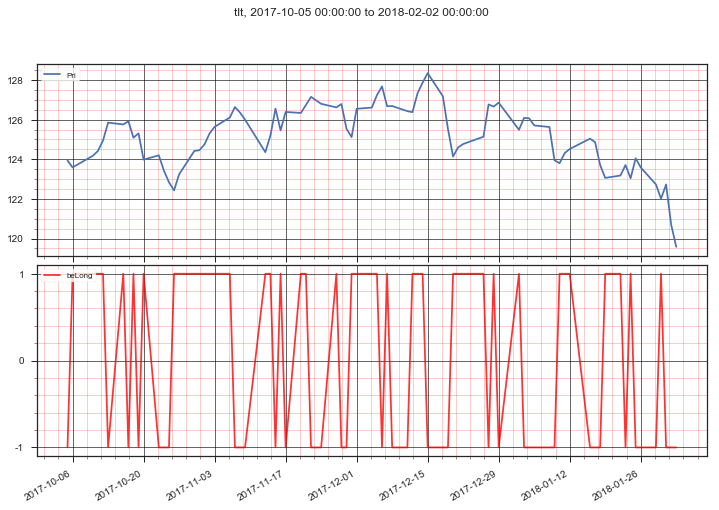

In [149]:
for i in range(segments):   
    df2 = pd.date_range(start=modelStartDate, end=modelEndDate, freq=us_cal)
    modelData = dataSet.reindex(df2)

    #modelData = dataSet.ix[modelStartDate:modelEndDate].copy()
    #print(modelData)
        
    # set target var
    #print(modelData.iloc[0])
    #print(modelEndDate)
    mmData = setTarget(modelData, "Long", beLongThreshold)
    nrows = mmData.shape[0]
    print ("nrows: ", nrows)
    print (mmData.shape)
    #print (mmData.tail(10))
    print ("beLong counts: ")
    print (mmData['beLong'].value_counts())
    print ("out of ", nrows)
    #print(modelData.head(2))
    #print(modelData.tail(2))
    plotTitle = issue + ", " + str(modelStartDate) + " to " + str(modelEndDate)
    plot_v2x(mmData['Pri'], mmData['beLong'], plotTitle)
    
    modelStartDate = modelEndDate  + BDay(1)
    modelEndDate = modelStartDate + relativedelta(months=inSampleMonths) - BDay(1)
    
    